In [1]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
# import tensorflow_io as tfio
import numpy as np 
import pandas as pd 
import PIL
import glob
import os
import matplotlib.pyplot as plt
import random
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('dark_background')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## 1. Example-Label pairing

Identify examples and labels

In [5]:
# data_dir = '/Users/shima/Library/CloudStorage/OneDrive-UniversiteitLeiden/My_Data/zebrafish/2018_Dataset/Test2/raw_new_data_good'
# data_dir = 'HR_Data'
# image_files = []
# mask_files = []

# # Loop over all folders and images in the specified split
# for folder in os.listdir(data_dir):
#     if not os.path.isdir(os.path.join(data_dir, folder)):
#         continue
#     for subfolder in os.listdir(os.path.join(data_dir, folder)):
#         if not os.path.isdir(os.path.join(data_dir, folder, subfolder)):
#             continue
#         image_folder = os.path.join(data_dir, folder, 'image')
#         mask_folder = os.path.join(data_dir, folder, 'labels')
# #              
#         for file in os.listdir(os.path.join(data_dir, folder, 'image')):
#             if file.endswith('.tif') and os.path.isfile(os.path.join(mask_folder, file)):
#                 image_file = os.path.join(image_folder, file)
#                 mask_file = os.path.join(mask_folder, file)
#                 image_files.append(image_file)
#                 mask_files.append((mask_file))
import os

data_dir = 'HR_Data'
image_files = []
mask_files = []

# Define directories for images and labels
image_folder = os.path.join(data_dir, 'image')
mask_folder = os.path.join(data_dir, 'labels')

# Loop over all images in the image folder
for file in os.listdir(image_folder):
    if file.endswith('.png'):
        # Check if corresponding label file exists in the labels folder
        if os.path.isfile(os.path.join(mask_folder, file)):
            image_file = os.path.join(image_folder, file)
            mask_file = os.path.join(mask_folder, file)
            image_files.append(image_file)
            mask_files.append(mask_file)


In [6]:
original=image_files
mask=mask_files
print(len(image_files))
print(len(mask_files))

93
93


In [7]:
mask_folder

'HR_Data/labels'

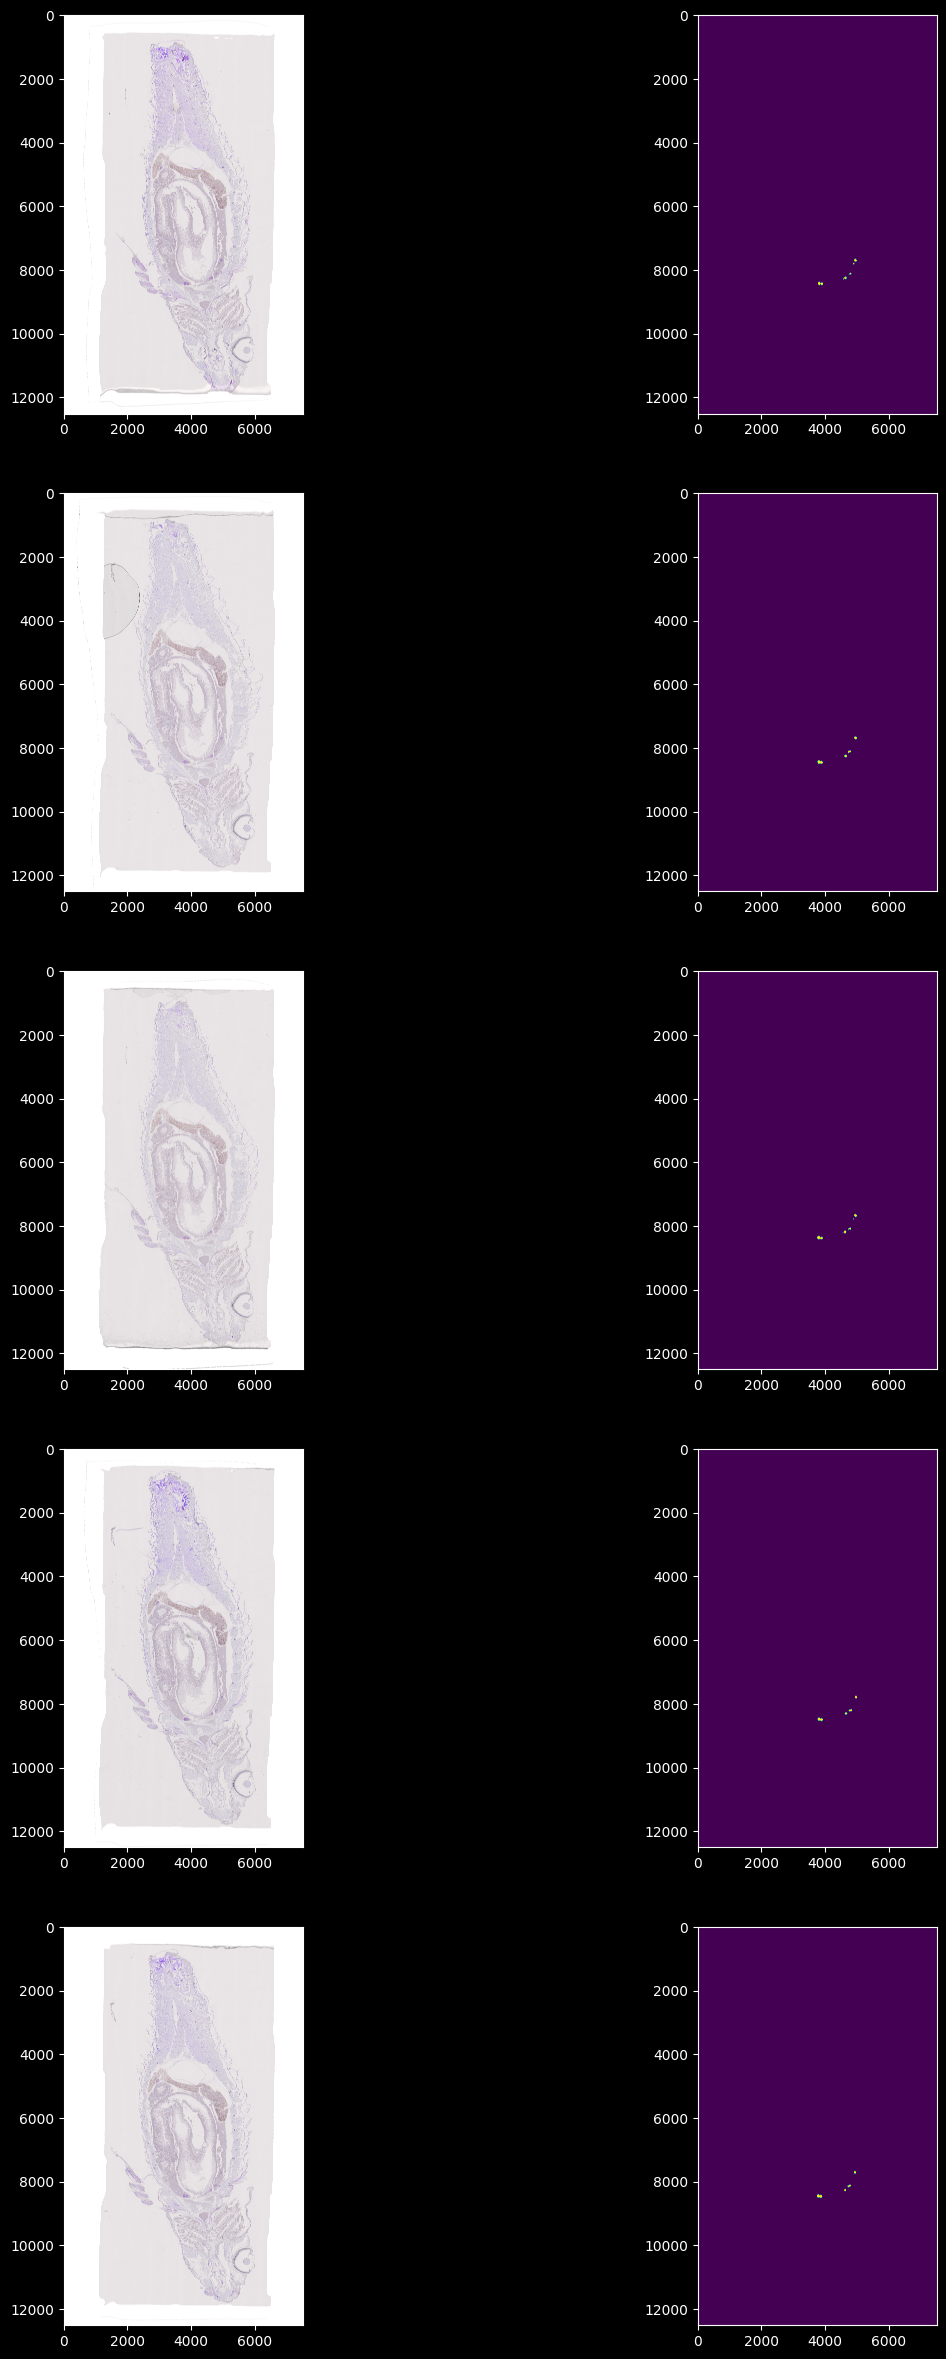

In [7]:
# 
# plt.imshow(cv2.imread(mask_files[0], cv2.IMREAD_UNCHANGED))
fig, axs = plt.subplots(5, 2, figsize=(15, 30))
for i in range(5):
    axs[i,0].imshow(cv2.imread(image_files[i], cv2.IMREAD_UNCHANGED))
    axs[i,1].imshow(cv2.imread(mask_files[i], cv2.IMREAD_UNCHANGED))
plt.show()


In [8]:
data = pd.DataFrame({'original': original, 'mask':mask})
data.head(10)

nSamples = len(original)
print('dataset features a total of: ',nSamples,' labelled examples')

dataset features a total of:  93  labelled examples


In [9]:
idx = np.random.randint(0,nSamples-1)
img = PIL.Image.open(data['original'][idx])
lbl = PIL.Image.open(data['mask'][idx])

fig, axs = plt.subplots(1,3,figsize=(15, 30))
axs[0].imshow(img), axs[0].set_title('original')
axs[1].imshow(lbl), axs[1].set_title('label')
axs[2].imshow(img), axs[2].set_title('manual segmentation')
axs[2].imshow(lbl, alpha=1 * (np.array(lbl) > 0))
fig.suptitle('Data')
fig.tight_layout()
plt.show()

/home/javanmardis/.local/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (93877542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ValueError: Unsupported dtype

<Figure size 1080x2160 with 3 Axes>

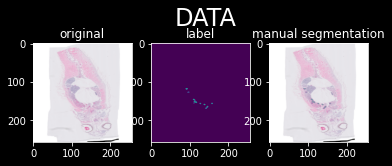

each example has dimension:  (256, 256)
each array has shape:     (256, 256, 3)
each lbl has dimension:  (256, 256)
each array lbl has shape:     (256, 256)


In [10]:
new_size = (256, 256)
idx = np.random.randint(0,nSamples-1)
img = PIL.Image.open(data['original'][idx])
img = img.resize(new_size)
lbl = PIL.Image.open(data['mask'][idx])
lbl = lbl.resize(new_size)

fig, axs = plt.subplots(1,3)
axs[0].imshow(img), axs[0].set_title('original')
axs[1].imshow(lbl), axs[1].set_title('label')
axs[2].imshow(img), axs[2].set_title('manual segmentation')
axs[2].imshow(lbl, alpha=0.5 * (np.array(lbl) > 0))
fig.suptitle('DATA', x=0.525, y=0.8, fontsize=24)
plt.show()

img_size = np.array(img).shape[:2]
img_shape= np.array(img).shape
lbl_size = np.array(lbl).shape[:2]
lbl_shape= np.array(lbl).shape

print('each example has dimension: ', img_size)
print('each array has shape:    ', img_shape)
print('each lbl has dimension: ', lbl_size)
print('each array lbl has shape:    ', lbl_shape)

In [11]:
img_size = np.array(img).shape[:2]
img_shape= np.array(img).shape

print('each example has dimension: ', img_size)
print('each array has shape:    ', img_shape)

each example has dimension:  (256, 256)
each array has shape:     (256, 256, 3)


## 2. Dataset creation

train - val splitting

In [12]:
x_train, x_test = train_test_split(data, test_size = 0.2, shuffle=True)

Data loading and preprocessing using Image Generators

In [13]:
BATCHSIZE = 2
def preprocess(img, mask):
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img, mask)

def create_gen(x):
    gen = ImageDataGenerator(
        rescale=1./255
    )

    img_gen = gen.flow_from_dataframe(pd.DataFrame(x), 
                                      x_col='original',
                                      class_mode=None, 
                                      target_size=(256, 256),
                                      batch_size=BATCHSIZE,
                                      shuffle=False
                                     )
    
    mask_gen = gen.flow_from_dataframe(pd.DataFrame(x), 
                                      x_col='mask',
                                      class_mode=None, 
                                      target_size=(256, 256),
                                      batch_size=BATCHSIZE,
                                      shuffle=False
                                     )
    generator = zip(img_gen, mask_gen)
    
    for (img, mask) in generator:
        img, mask = preprocess(img, mask)
        yield (img, mask)

train = create_gen(x_train)
val = create_gen(x_test)

In [14]:
print(img_shape)

(256, 256, 3)


## 3. Model creation
4 layers U-Net

In [15]:
img_input = layers.Input(img_shape)

# Block 1
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = layers.BatchNormalization()(x)
block_1_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_1_out)

# Block 2
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = layers.BatchNormalization()(x)
block_2_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_2_out)

# Block 3
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = layers.BatchNormalization()(x)
block_3_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_3_out)

# Block 4
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = layers.BatchNormalization()(x)
block_4_out = layers.Activation('relu')(x)

# UP 1
x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_3_out])
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# UP 2
x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_2_out])
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# UP 3
x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_1_out])
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(img_input, x)
# model.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy', metrics=['mse','accuracy'])

In [16]:
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
# def f1_score(y_true, y_pred): 
#     precision = metrics.Precision()(y_true, y_pred)
#     recall = metrics.Recall()(y_true, y_pred)
#     f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
#     return f1

class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=[metrics.MeanSquaredError(),
                       metrics.BinaryAccuracy(),
                       metrics.Precision(),
                       metrics.Recall(),
                       F1Score()])


In [17]:
# Check the shape of input and output for train generator
x_train_sample, y_train_sample = next(iter(train))
print("Train input shape:", x_train_sample.shape)
print("Train output shape:", y_train_sample.shape)

# Check the shape of input and output for validation generator
x_val_sample, y_val_sample = next(iter(val))
print("Validation input shape:", x_val_sample.shape)
print("Validation output shape:", y_val_sample.shape)

Found 74 validated image filenames.
Found 74 validated image filenames.
Train input shape: (2, 256, 256, 3)
Train output shape: (2, 256, 256, 3)
Found 19 validated image filenames.
Found 19 validated image filenames.
Validation input shape: (2, 256, 256, 3)
Validation output shape: (2, 256, 256, 3)


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

## 4. Model training

In [19]:
history = model.fit(train, 
          epochs=100, 
          validation_data= val,
          steps_per_epoch= len(x_train)// BATCHSIZE,
          validation_steps= len(x_test) // BATCHSIZE,
          verbose=1
          )

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 0.2193 - mean_squared_error: 0.0574 - binary_accuracy: 0.9404 - precision: 9.4708e-04 - recall: 0.0673 - f1_score: 0.0019

c:\Users\mehrdad\Anaconda3\envs\e18\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


37/37 [==============================] - 156s 4s/step - loss: 0.2193 - mean_squared_error: 0.0574 - binary_accuracy: 0.9404 - precision: 9.4708e-04 - recall: 0.0673 - f1_score: 0.0019 - val_loss: 0.1927 - val_mean_squared_error: 0.0318 - val_binary_accuracy: 0.9993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/100
37/37 [==============================] - 143s 4s/step - loss: 0.0195 - mean_squared_error: 0.0012 - binary_accuracy: 0.9992 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.0637 - val_mean_squared_error: 0.0045 - val_binary_accuracy: 0.9993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/100
37/37 [==============================] - 144s 4s/step - loss: 0.0105 - mean_squared_error: 8.5933e-04 - binary_accuracy: 0.9992 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.0304 - val_mean_squared_error: 0.0016 - val_binary_accuracy: 0.999

In [20]:
model.save('model2.h5')

In [21]:
#Load Model
# from tensorflow.keras.models import load_model

# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.precision = tf.keras.metrics.Precision()
#         self.recall = tf.keras.metrics.Recall()

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         self.precision.update_state(y_true, y_pred, sample_weight)
#         self.recall.update_state(y_true, y_pred, sample_weight)

#     def result(self):
#         precision = self.precision.result()
#         recall = self.recall.result()
#         return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

#     def reset_states(self):
#         self.precision.reset_states()
#         self.recall.reset_states()

# model = load_model('model2.h5', custom_objects={'F1Score': F1Score})

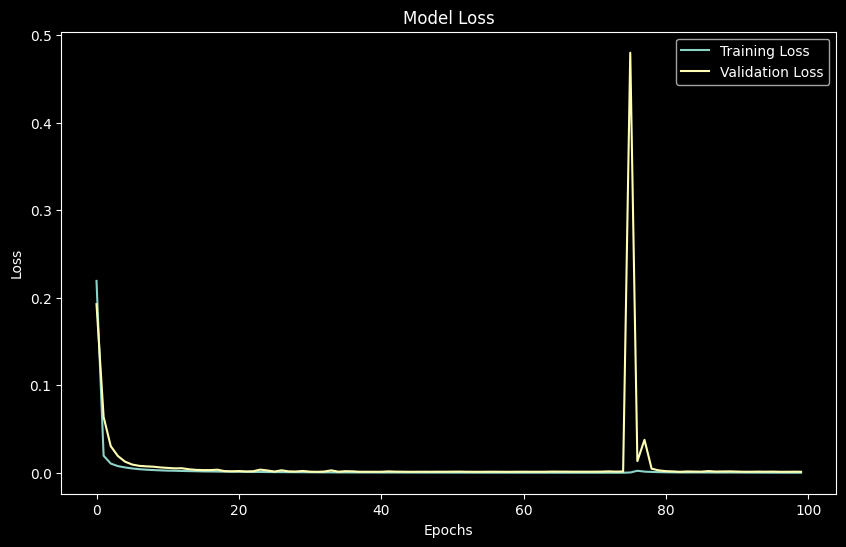

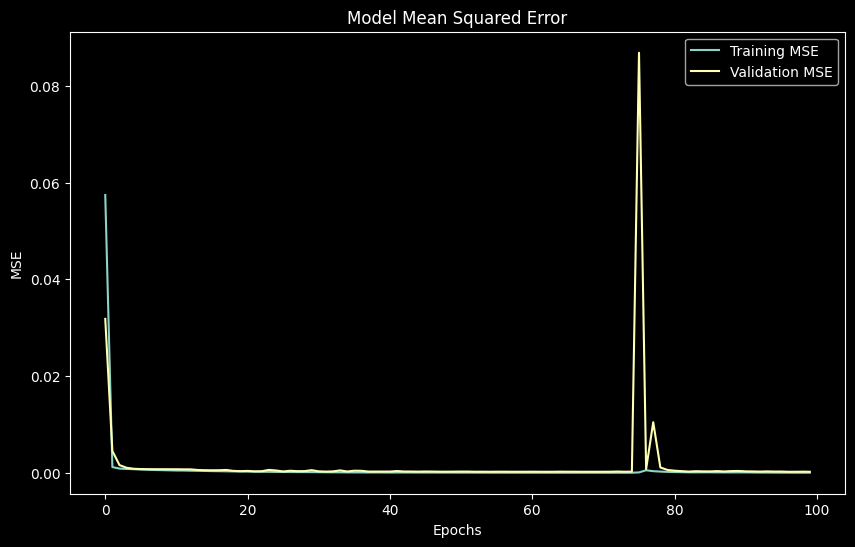

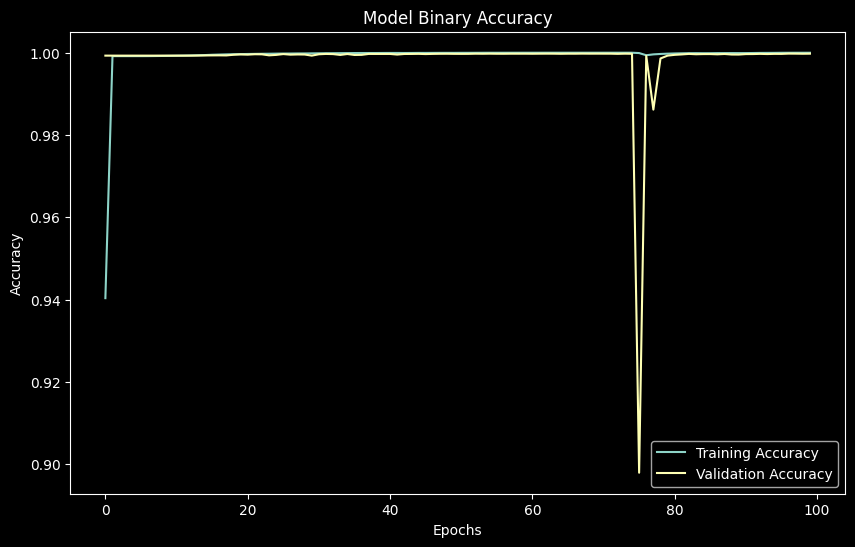

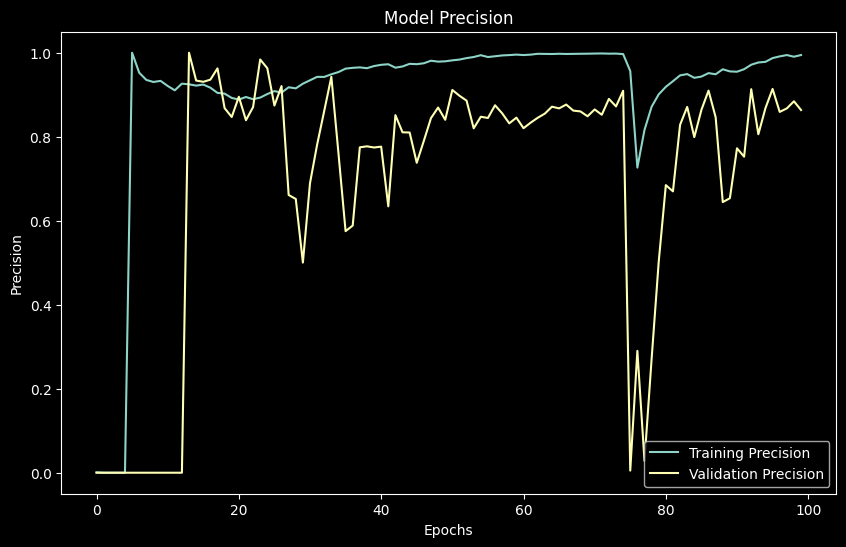

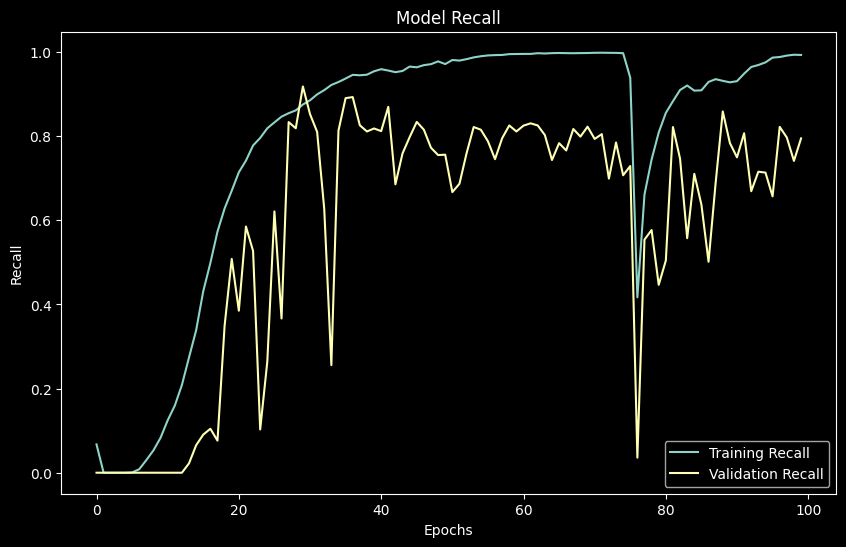

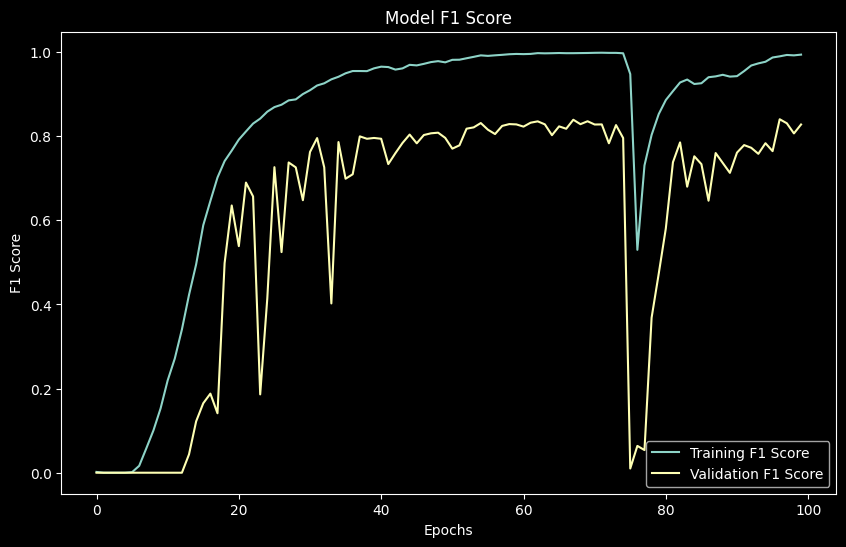

In [22]:
# plot the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

# plot the mean squared error
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

# plot the binary accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Binary Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# plot the precision
plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# plot the recall
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# plot the F1 score
plt.figure(figsize=(10, 6))
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

C:\Users\mehrdad\AppData\Local\Temp\ipykernel_20328\3526613264.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


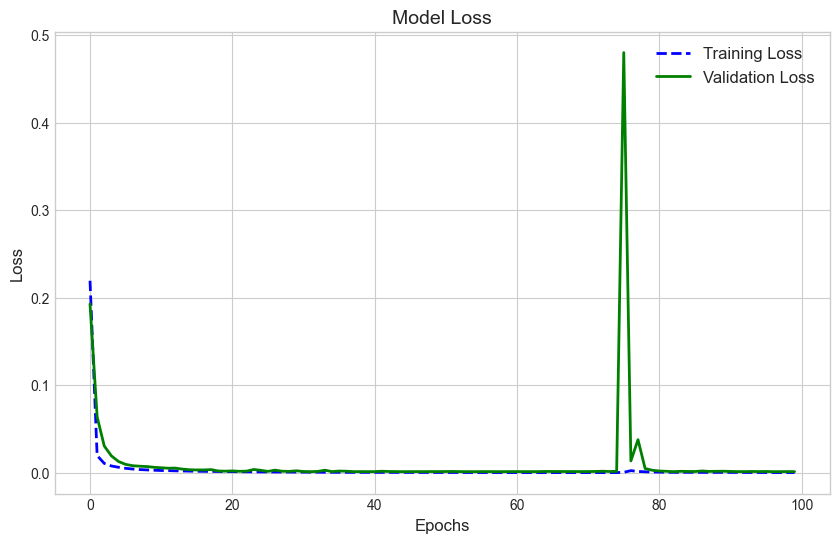

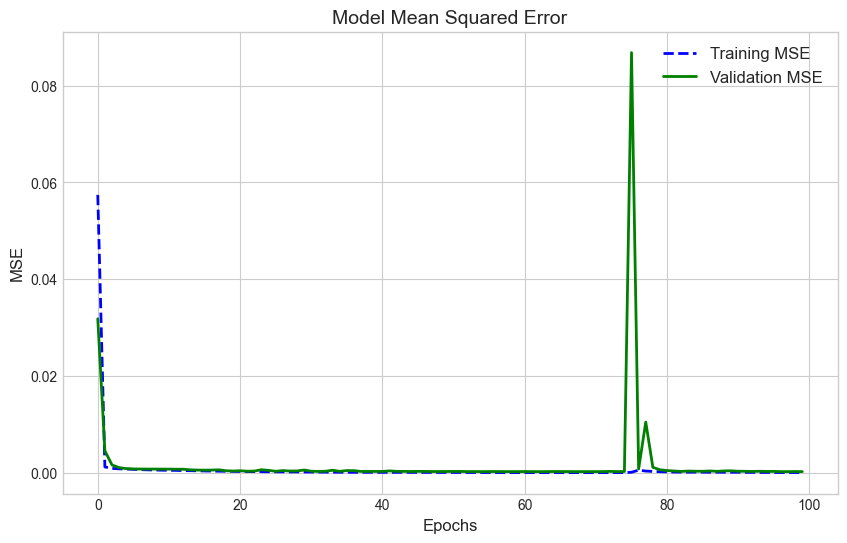

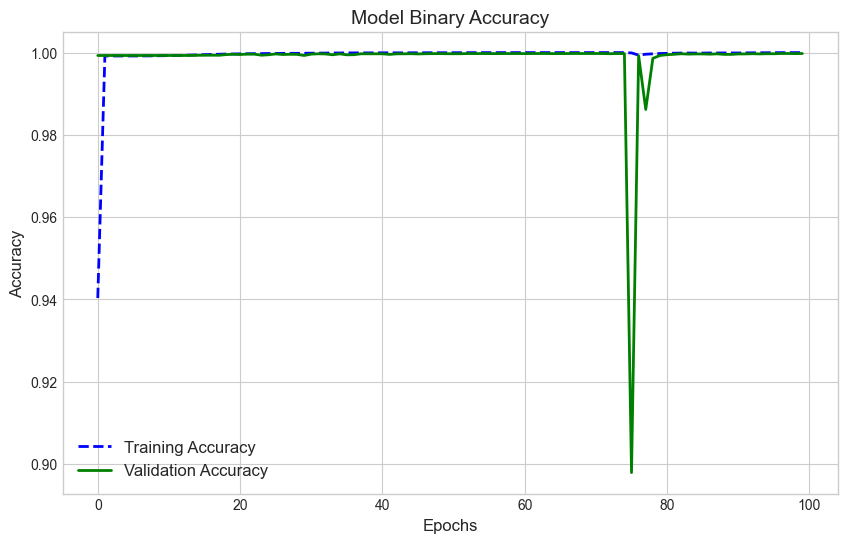

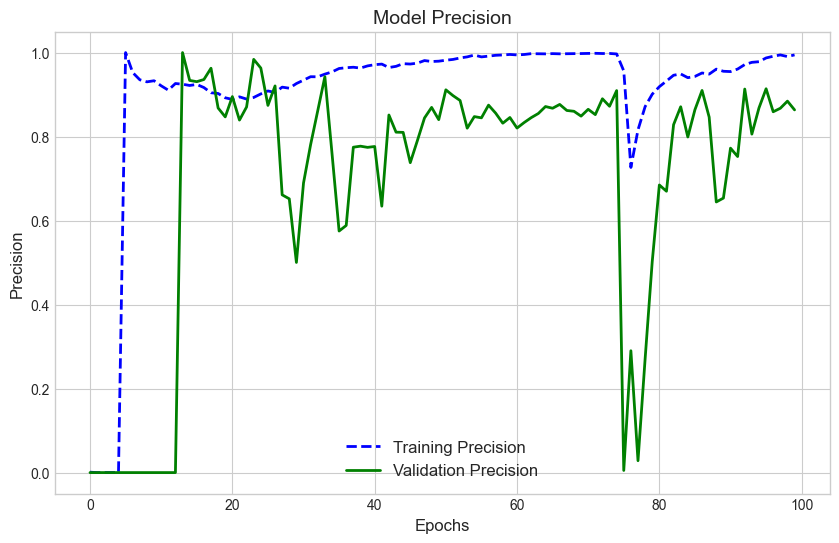

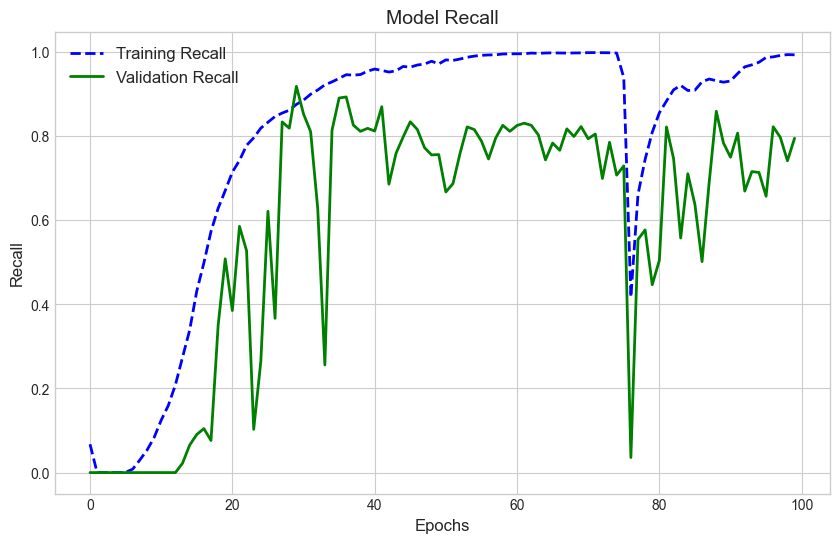

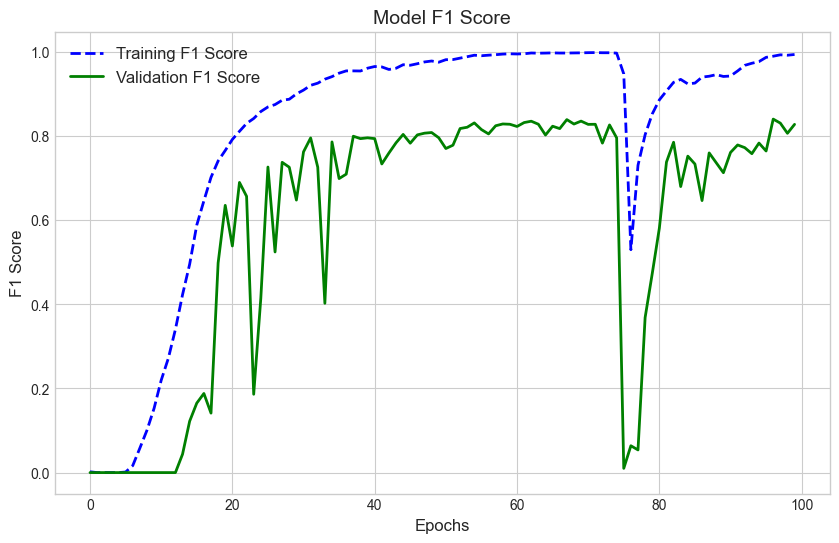

In [23]:
#Nice visualization for paper

plt.style.use('seaborn-whitegrid')

metrics = [
    ('loss', 'Training Loss', 'Validation Loss', 'Model Loss', 'Loss'),
    ('mean_squared_error', 'Training MSE', 'Validation MSE', 'Model Mean Squared Error', 'MSE'),
    ('binary_accuracy', 'Training Accuracy', 'Validation Accuracy', 'Model Binary Accuracy', 'Accuracy'),
    ('precision', 'Training Precision', 'Validation Precision', 'Model Precision', 'Precision'),
    ('recall', 'Training Recall', 'Validation Recall', 'Model Recall', 'Recall'),
    ('f1_score', 'Training F1 Score', 'Validation F1 Score', 'Model F1 Score', 'F1 Score')
]

for metric_name, train_label, val_label, title, ylabel in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric_name], 'b--', linewidth=2, label=train_label)
    plt.plot(history.history['val_' + metric_name], 'g-', linewidth=2, label=val_label)
    plt.title(title, fontsize=14)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel('Epochs', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.savefig(f'{metric_name}.png', dpi=300)
    plt.show()


## 5. Evaluation

In [24]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)
  
  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    
    return x


c:\Users\mehrdad\Anaconda3\envs\e18\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93877542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 339ms/step


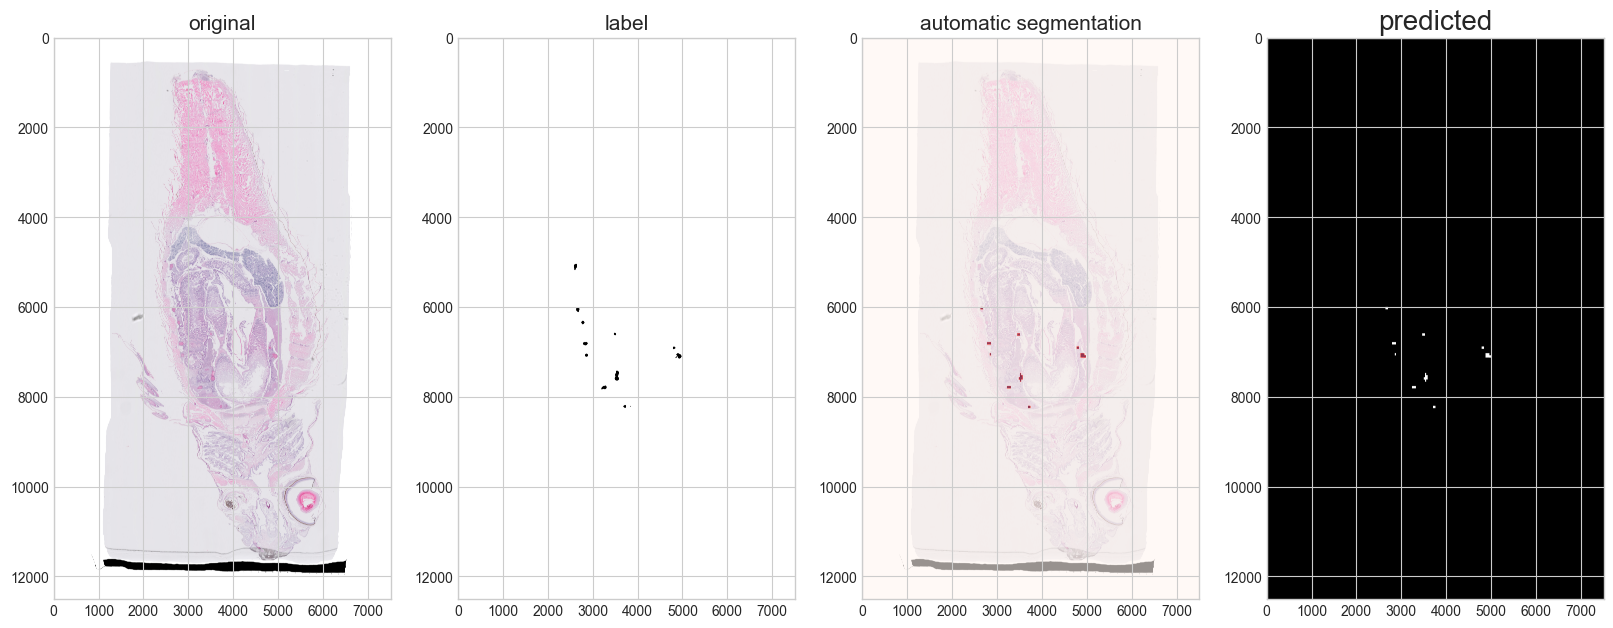

1/1 [==============================] - 0s 23ms/step


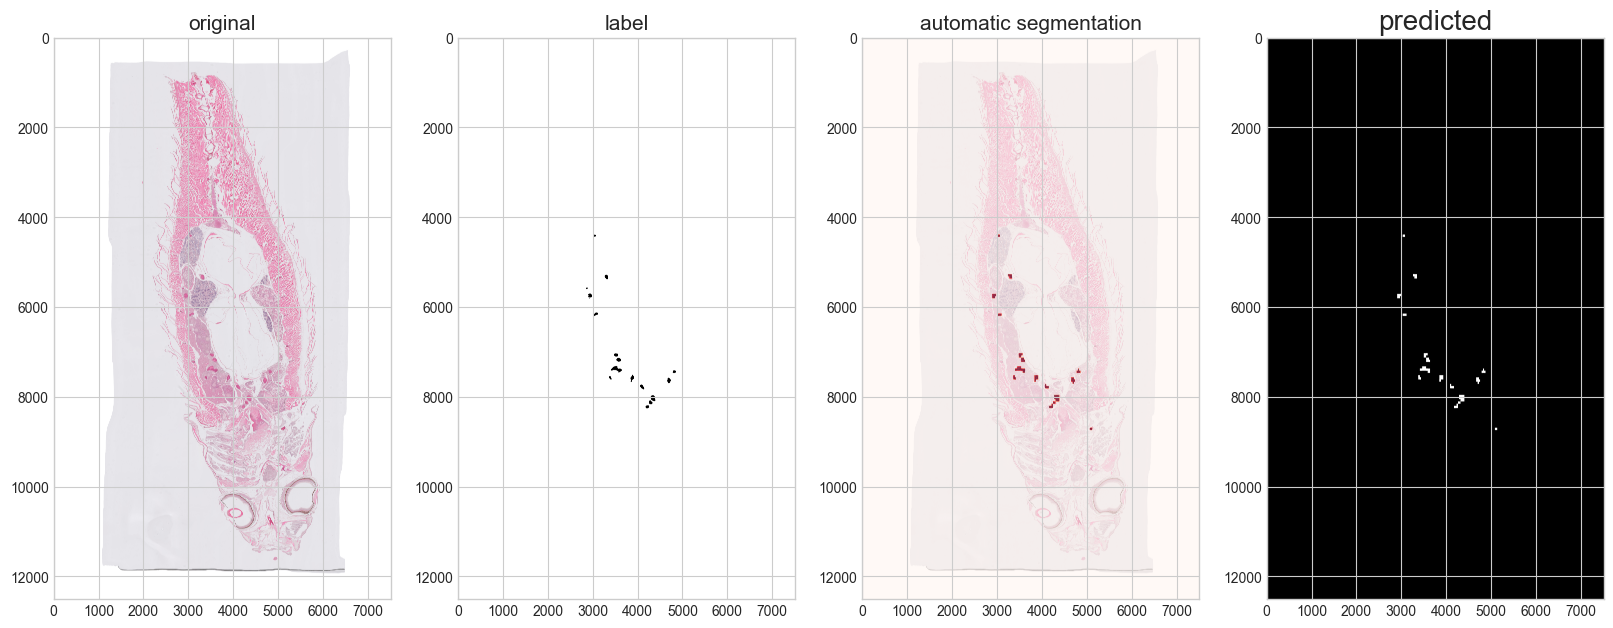

1/1 [==============================] - 0s 32ms/step


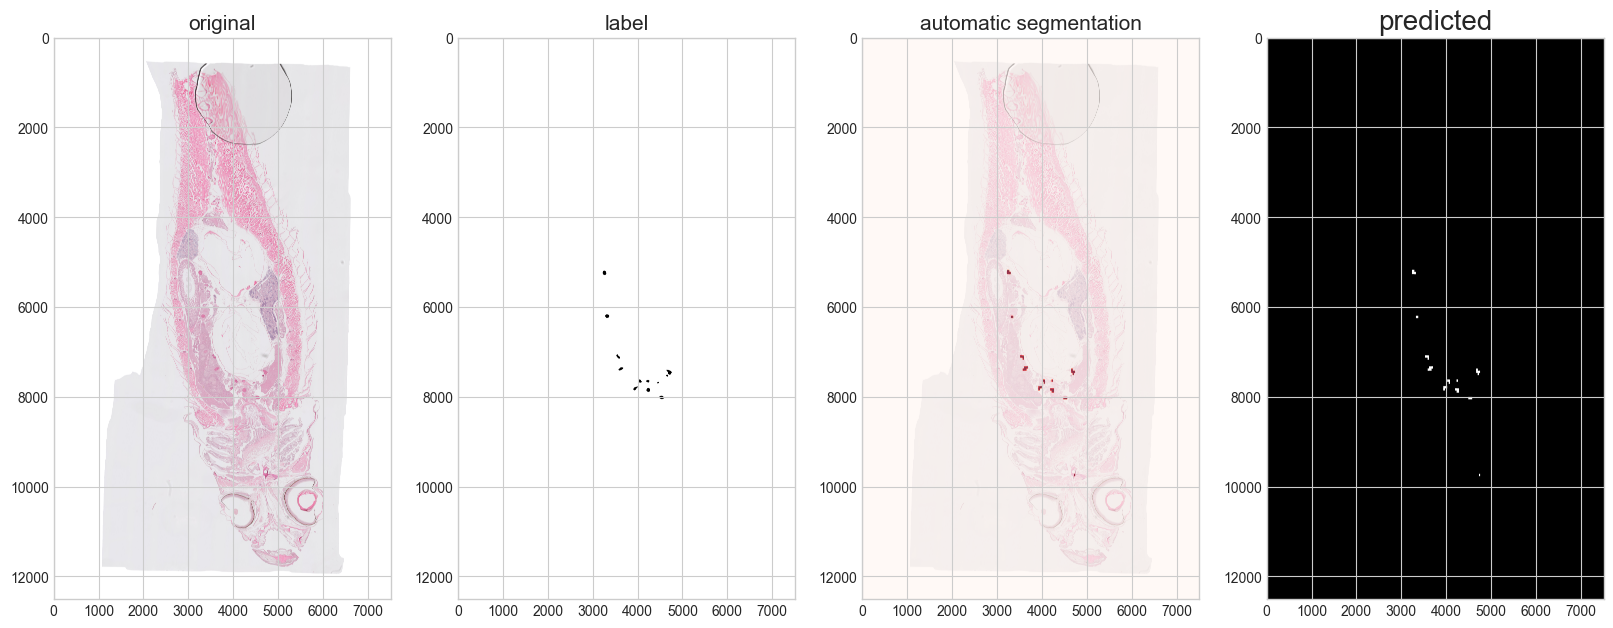

1/1 [==============================] - 0s 40ms/step


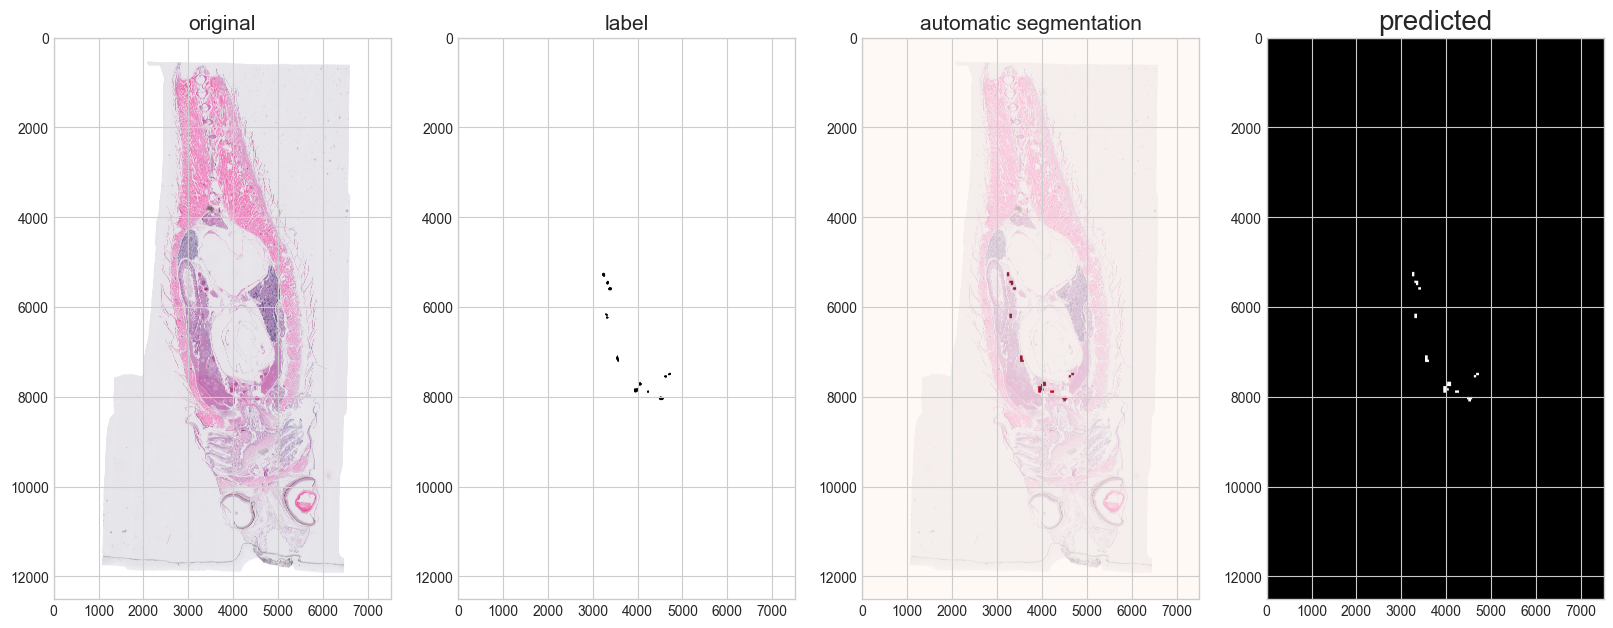

1/1 [==============================] - 0s 25ms/step


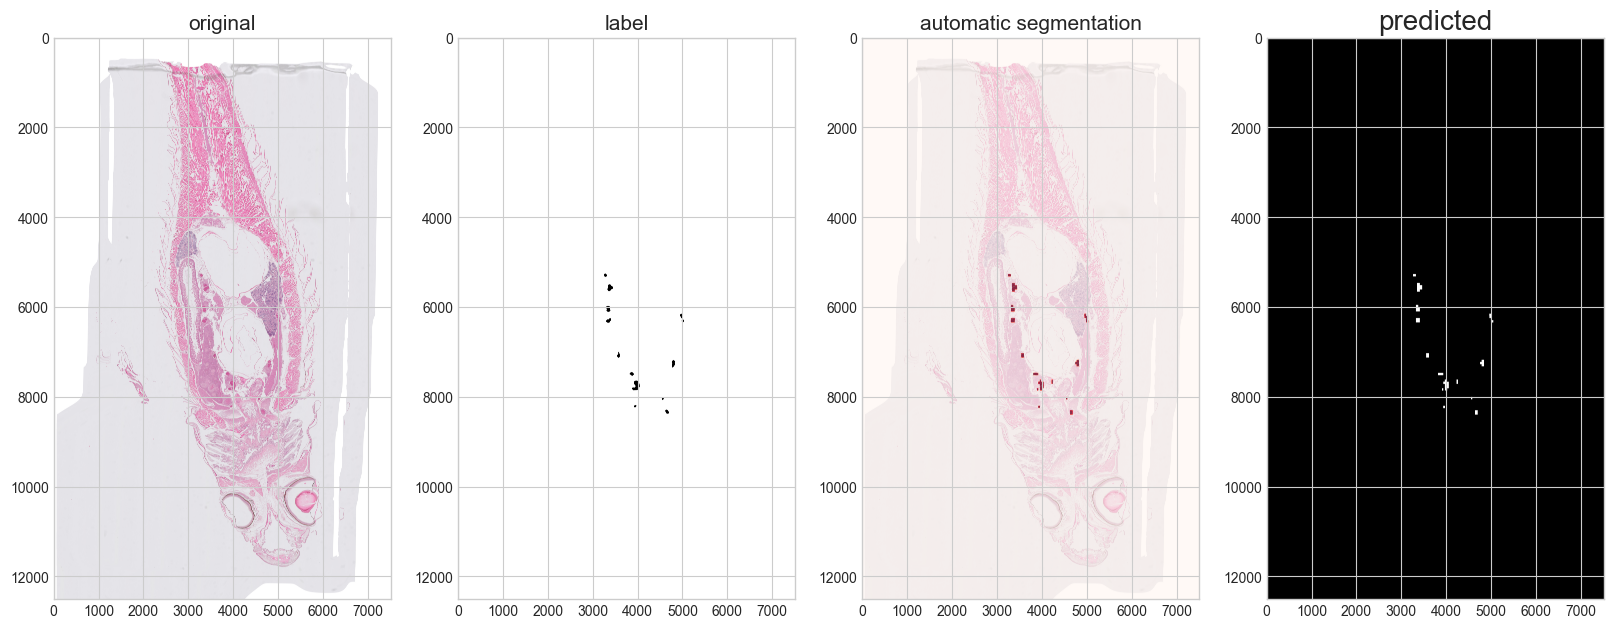

In [26]:
import uuid
if not(os.path.exists('Model2_output')):
    os.mkdir('Model2_output')

nSaveImages = 5  # Only generate 5 images
for im in range(nSaveImages):
    cols = 4
    fig, axs = plt.subplots(1, cols, figsize=(20, 10))  # Only 1 row, and increase figure size for better visualization   

    idx = np.random.randint(0, nSamples-1)
    img = PIL.Image.open(data['original'][idx])
    lbl = PIL.Image.open(data['mask'][idx])
    original_size = img.size  # save the original size
    img_resized = img.resize(new_size)
    lbl_resized = lbl.resize(new_size)

    pred = model.predict(np.expand_dims(np.array(img_resized) / 255, 0))
    # Convert probabilities into binary mask
    binary_mask = np.where(pred[0]>0.5, 1, 0)

    # Convert binary mask to PIL image
    pred_resized = PIL.Image.fromarray(binary_mask.astype(np.uint8)).resize(original_size)

    axs[0].imshow(img), axs[0].set_title('original', fontsize=15)
    axs[1].imshow(lbl), axs[1].set_title('label', fontsize=15)

    # Plotting the original image with the prediction mask (resized to the original size) overlaid
    axs[2].imshow(img), axs[2].set_title('automatic segmentation', fontsize=15)
    axs[2].imshow(np.array(pred_resized)[:, :, 0], alpha=0.6, cmap='Reds')

    axs[3].imshow(np.array(pred_resized)[:, :, 0], cmap='gray'), axs[3].set_title('predicted', fontsize=20)

    plt.show()

    fig.suptitle('MODEL EVALUATION', fontsize=30)

    # Resize the final plot to (512,256) and save
    final_img = np.asarray(fig.canvas.renderer.buffer_rgba())[:, :, :-1]
    final_img = cv2.resize(final_img, (512, 256))
    figname = uuid.uuid1()
    cv2.imwrite('Model2_output/'+str(figname)+'.png', final_img)
    plt.close()


In [27]:
print(np.max(pred_resized))

1
